In [4]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd

# from osgeo import gdal
import fiona
import geopandas as gpd

In [5]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [6]:
# Read the shoreline and bluff edges into a GeoDataFrame (to get get intersection points with transect)
gdf_be = gpd.read_file('raw_datasets/gibbs/BarterIsland_BluffEdge_1950to2020.zip')
gdf_sl = gpd.read_file('raw_datasets/gibbs/BarterIsland_Shoreline_1947to2020.zip')

# Read the shoreline and bluff edge change rate into a GeoDataFrame (to get transects)
gdf_be_cr = gpd.read_file('raw_datasets/gibbs/BarterIsland_BluffTransect_ChangeRates_1950to2020.zip')
# gdf_sl_cr = gpd.read_file('raw_datasets/gibbs/BarterIsland_ShoreTransect_ChangeRates_1947to2020.zip')  # not required, transects from bluff edge are used

# Read the bluff edge baseline into a GeoDataFrame (as a reference for the coastal retreat)
gdf_be_bl = gpd.read_file('raw_datasets/gibbs/BarterIsland_BluffEdgeBaseline.zip')


In [7]:
gdf_be.crs

<Projected CRS: EPSG:26907>
Name: NAD83 / UTM zone 7N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 144°W and 138°W - onshore and offshore. Canada - British Columbia; Yukon. United States (USA) - Alaska.
- bounds: (-144.0, 52.05, -137.99, 73.59)
Coordinate Operation:
- name: UTM zone 7N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
gdf_be_cr.geometry.values.unique()

<GeometryArray>
[<LINESTRING (400599.74 7783102.453, 400599.74 7783102.444, 400585.778 778280...>,
 <LINESTRING (400592.001 7783102.805, 400592.001 7783102.805, 400578.011 7782...>,
 <LINESTRING (400582.012 7783103.272, 400582.012 7783103.272, 400568.022 7782...>,
 <LINESTRING (400572.023 7783103.738, 400572.023 7783103.738, 400558.033 7782...>,
 <LINESTRING (400562.034 7783104.204, 400562.034 7783104.204, 400548.044 7782...>,
 <LINESTRING (400552.045 7783104.671, 400552.045 7783104.671, 400538.055 7782...>,
 <LINESTRING (400542.056 7783105.137, 400542.056 7783105.137, 400528.065 7782...>,
 <LINESTRING (400532.067 7783105.603, 400532.067 7783105.603, 400518.076 7782...>,
 <LINESTRING (400522.077 7783106.07, 400522.077 7783106.07, 400508.087 778280...>,
 <LINESTRING (400512.088 7783106.536, 400512.088 7783106.536, 400498.098 7782...>,
 ...
 <LINESTRING (397452.427 7783072.374, 397452.427 7783072.374, 397491.554 7782...>,
 <LINESTRING (397442.513 7783071.07, 397442.513 7783071.07, 397481

In [9]:
transect_ids = np.arange(130, 140, 1)

transects = [gdf_be_cr[gdf_be_cr.TransectID==id].to_crs(crs="4326") for id in transect_ids]

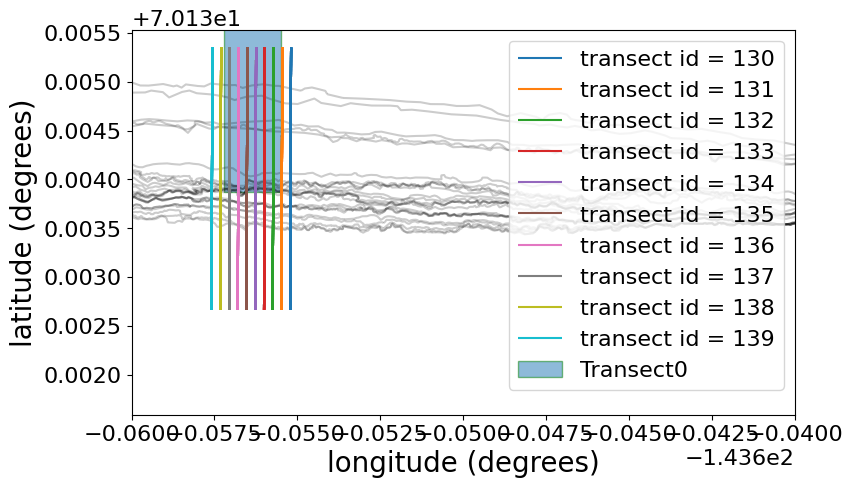

In [10]:
mask0 = ((-143.6571995, -143.6554848), (70.133872, 70.1410771))
patch0 = Rectangle((mask0[0][0], mask0[1][0]), width=mask0[0][1]-mask0[0][0], height=mask0[1][1]-mask0[1][0],
                   facecolor=None, edgecolor='green', alpha=0.5, label='Transect0')


fig, ax = plt.subplots(figsize=(15, 5))

gdf_be.to_crs(crs="4326").plot(ax=ax, color='black', alpha=0.2)
# gdf_sl.plot(ax=ax, color='blue', alpha=0.2)

i = 0

for id, transect in zip(transect_ids, transects):
    transect.plot(ax=ax, label=f'transect id = {id}', color=f'C{i}')
    i+=1

ax.set_xlabel("longitude (degrees)")
ax.set_ylabel("latitude (degrees)")

ax.add_patch(patch0)

ax.set_xlim((-143.66, -143.64))

ax.legend()

plt.show()

plt.close()

It would seem that transect id 134 is the best here.

In [11]:
def get_timeseries(gdf, gdf_changerate, gdf_baseline, transect_id):
    """
    Returns timeseries for bluff edge or shoreline depending on the given gdf.
    --------------
    gdf_changerate: 
        used to obtain the transect
    transect_id:
        transect id used to determine for which transect the timeseries is returned
    gdf:
        timeseries is determined from this gdf
    """

    # initialize dates, intersects and distance_from_ref(erence point) timeseries
    dates = []
    intersects = []
    distance_from_ref = []

    # get transect from changerate geodataframe
    transect = gdf_changerate[gdf_changerate.TransectID==transect_id].geometry.values[0]

    # get reference point from intersection baseline geodataframe
    ref = gdf_baseline.geometry.intersection(transect)
    # display(ref)

    # loop through all rows of geodataframe (each row represents a coastline, should end up with 25 points for all 25 measurement dates)
    for index, row in gdf.iterrows():

        intersect = row.geometry.intersection(transect)

        # check if there is an intersection (for some reason not each row gives an intersect)
        if not intersect.is_empty:
            
            # calculate distance from reference point to bluff edge
            d = intersect.distance(ref)

            # save date and intersect and distance
            dates.append(row.Date_)
            intersects.append(intersect)
            distance_from_ref.append(d)

    # create a geodataframe from the resulting dates, intersects, distances from reference. Also includes transect id and reference point
    result = gpd.GeoDataFrame(data={
        "date": dates,
        "distance_from_ref": distance_from_ref,
        "transect_id": np.ones(len(dates)) * transect_id,
        "ref_point": [ref]*len(dates)
        
    }, geometry=intersects, crs=gdf.crs)

    # finally we convert the dates to datetime for easy plotting
    result['date'] = pd.to_datetime(result['date'])

    return result

c:\Users\bruij_kn\AppData\Local\mambaforge\envs\thesis\Lib\site-packages\matplotlib\cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
c:\Users\bruij_kn\AppData\Local\mambaforge\envs\thesis\Lib\site-packages\matplotlib\collections.py:197: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  offsets = np.asanyarray(offsets, float)


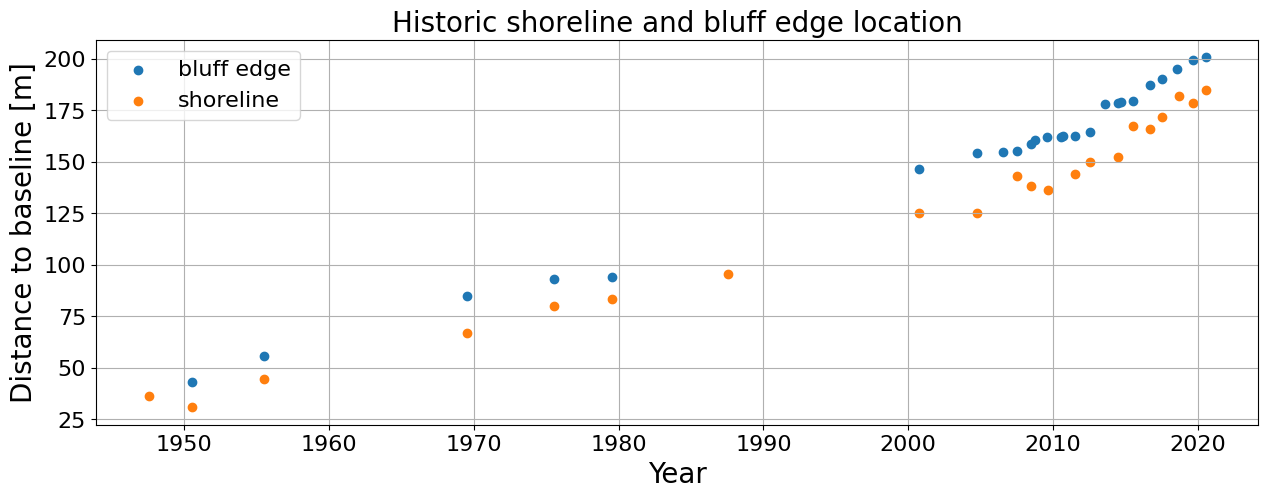

In [12]:
transect_id = 134

fig, ax = plt.subplots(figsize=(15, 5))

bluff_edges = get_timeseries(gdf_be, gdf_be_cr, gdf_be_bl, transect_id).to_crs(crs="4326")
shore_lines = get_timeseries(gdf_sl, gdf_be_cr, gdf_be_bl, transect_id).to_crs(crs="4326")

ax.scatter(bluff_edges.date, bluff_edges.distance_from_ref, label='bluff edge', color='C0')
ax.scatter(shore_lines.date, shore_lines.distance_from_ref, label='shoreline', color='C1')
# ax.plot(bluff_edges.date, bluff_edges.distance_from_ref, color='C0')
# ax.plot(shore_lines.date, shore_lines.distance_from_ref, color='C1')

ax.set_xlabel("Year")
ax.set_ylabel("Distance to baseline [m]")

ax.grid()

ax.set_title("Historic shoreline and bluff edge location")

ax.legend()

save_path = Path("C:/Users/bruij_kn/OneDrive - Stichting Deltares/Documents/GitHub/msc-thesis/Figures/Python")

figname = 'retreat_rates_data.png'

plt.savefig(os.path.join(save_path, figname), bbox_inches='tight', facecolor='white', transparent=False)

c:\Users\bruij_kn\AppData\Local\mambaforge\envs\thesis\Lib\site-packages\matplotlib\cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
c:\Users\bruij_kn\AppData\Local\mambaforge\envs\thesis\Lib\site-packages\matplotlib\collections.py:197: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  offsets = np.asanyarray(offsets, float)
c:\Users\bruij_kn\AppData\Local\mambaforge\envs\thesis\Lib\site-packages\matplotlib\cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
c:\Users\bruij_kn\AppData\Local\mambaforge\envs\thesis\Lib\site-packages\matplotlib\cbook.py:1398: FutureWarning: Calling float on a single element Series is deprecated an

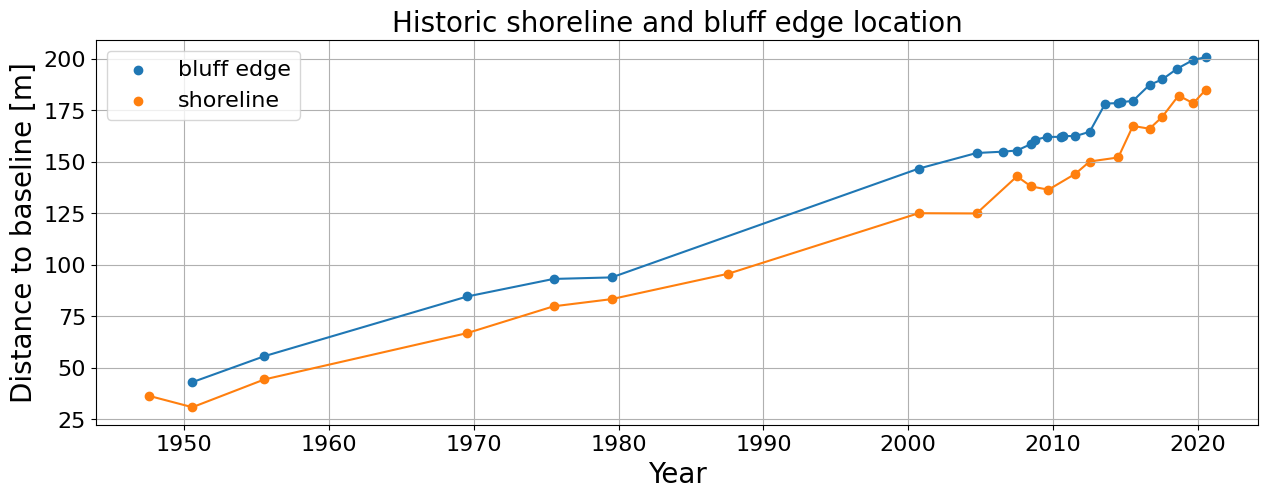

In [16]:
transect_id = 134

fig, ax = plt.subplots(figsize=(15, 5))

bluff_edges = get_timeseries(gdf_be, gdf_be_cr, gdf_be_bl, transect_id).to_crs(crs="4326")
shore_lines = get_timeseries(gdf_sl, gdf_be_cr, gdf_be_bl, transect_id).to_crs(crs="4326")

sort_mask_be = np.argsort(bluff_edges.date.values)
sort_mask_sl = np.argsort(shore_lines.date.values)

ax.scatter(bluff_edges.date, bluff_edges.distance_from_ref, label='bluff edge', color='C0')
ax.scatter(shore_lines.date, shore_lines.distance_from_ref, label='shoreline', color='C1')
ax.plot(bluff_edges.date[sort_mask_be], bluff_edges.distance_from_ref[sort_mask_be], color='C0')
ax.plot(shore_lines.date[sort_mask_sl], shore_lines.distance_from_ref[sort_mask_sl], color='C1')

ax.set_xlabel("Year")
ax.set_ylabel("Distance to baseline [m]")

ax.grid()

ax.set_title("Historic shoreline and bluff edge location")

ax.legend()

save_path = Path("C:/Users/bruij_kn/OneDrive - Stichting Deltares/Documents/GitHub/msc-thesis/Figures/Python")

figname = 'retreat_rates_data2.png'

plt.savefig(os.path.join(save_path, figname), bbox_inches='tight', facecolor='white', transparent=False)

c:\Users\bruij_kn\AppData\Local\mambaforge\envs\thesis\Lib\site-packages\matplotlib\cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
c:\Users\bruij_kn\AppData\Local\mambaforge\envs\thesis\Lib\site-packages\matplotlib\collections.py:197: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  offsets = np.asanyarray(offsets, float)
c:\Users\bruij_kn\AppData\Local\mambaforge\envs\thesis\Lib\site-packages\matplotlib\cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
c:\Users\bruij_kn\AppData\Local\mambaforge\envs\thesis\Lib\site-packages\matplotlib\cbook.py:1398: FutureWarning: Calling float on a single element Series is deprecated an

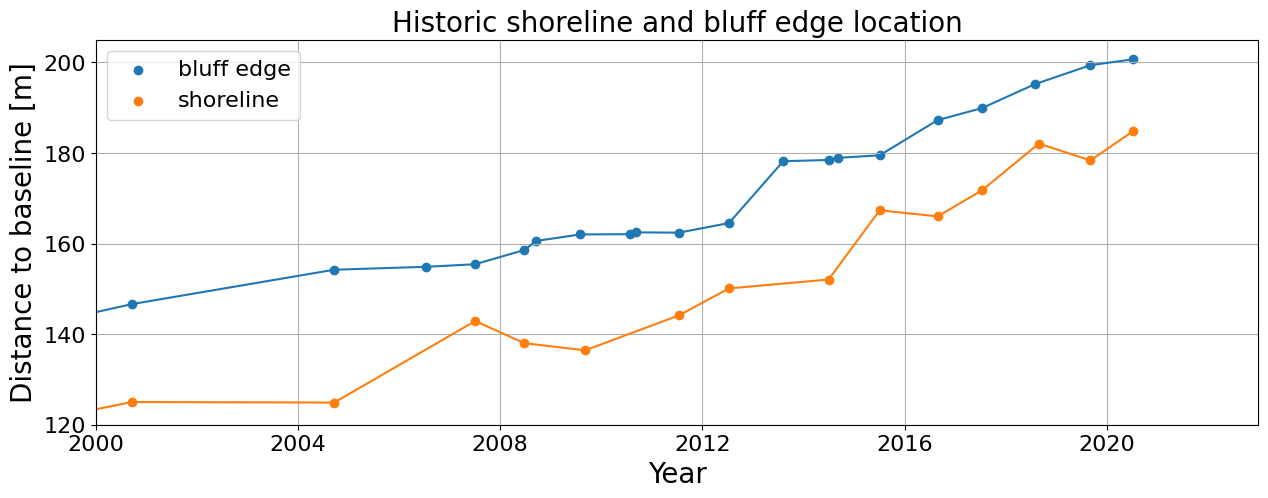

In [21]:
transect_id = 134

fig, ax = plt.subplots(figsize=(15, 5))

bluff_edges = get_timeseries(gdf_be, gdf_be_cr, gdf_be_bl, transect_id).to_crs(crs="4326")
shore_lines = get_timeseries(gdf_sl, gdf_be_cr, gdf_be_bl, transect_id).to_crs(crs="4326")

sort_mask_be = np.argsort(bluff_edges.date.values)
sort_mask_sl = np.argsort(shore_lines.date.values)

ax.scatter(bluff_edges.date, bluff_edges.distance_from_ref, label='bluff edge', color='C0')
ax.scatter(shore_lines.date, shore_lines.distance_from_ref, label='shoreline', color='C1')
ax.plot(bluff_edges.date[sort_mask_be], bluff_edges.distance_from_ref[sort_mask_be], color='C0')
ax.plot(shore_lines.date[sort_mask_sl], shore_lines.distance_from_ref[sort_mask_sl], color='C1')

ax.set_xlabel("Year")
ax.set_ylabel("Distance to baseline [m]")
ax.set_xlim((pd.to_datetime("2000-01-01"), pd.to_datetime("2023-01-01")))
ax.set_ylim(120, 205)

ax.grid()

ax.set_title("Historic shoreline and bluff edge location")

ax.legend()

save_path = Path("C:/Users/bruij_kn/OneDrive - Stichting Deltares/Documents/GitHub/msc-thesis/Figures/Python")

figname = 'retreat_rates_data3.png'

plt.savefig(os.path.join(save_path, figname), bbox_inches='tight', facecolor='white', transparent=False)

c:\Users\bruij_kn\AppData\Local\mambaforge\envs\thesis\Lib\site-packages\matplotlib\cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
c:\Users\bruij_kn\AppData\Local\mambaforge\envs\thesis\Lib\site-packages\matplotlib\collections.py:194: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  offsets = np.asanyarray(offsets, float)


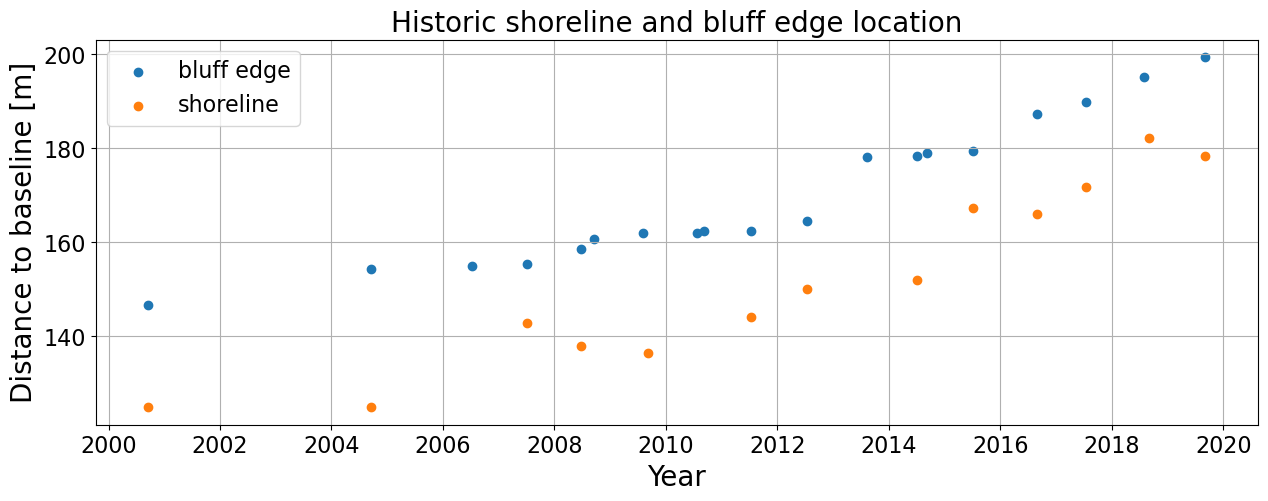

In [25]:
transect_id = 134

fig, ax = plt.subplots(figsize=(15, 5))

bluff_edges = get_timeseries(gdf_be, gdf_be_cr, gdf_be_bl, transect_id).to_crs(crs="4326")
shore_lines = get_timeseries(gdf_sl, gdf_be_cr, gdf_be_bl, transect_id).to_crs(crs="4326")

t_start, t_end = pd.Timestamp(2000, 1, 1), pd.Timestamp(2020, 1, 1)
bluff_edges_masked = bluff_edges.loc[bluff_edges.date > t_start].loc[bluff_edges.date < t_end]
shore_lines_masked = shore_lines.loc[shore_lines.date > t_start].loc[shore_lines.date < t_end]

ax.scatter(bluff_edges_masked.date, bluff_edges_masked.distance_from_ref, label='bluff edge', color='C0')
ax.scatter(shore_lines_masked.date, shore_lines_masked.distance_from_ref, label='shoreline', color='C1')

ax.set_xlabel("Year")
ax.set_ylabel("Distance to baseline [m]")

ax.grid()

ax.set_title("Historic shoreline and bluff edge location")

ax.legend()

save_path = Path("C:/Users/bruij_kn/OneDrive - Stichting Deltares/Documents/GitHub/msc-thesis/Figures/Python")

figname = 'retreat_rates_data.png'

plt.savefig(os.path.join(save_path, figname), bbox_inches='tight', facecolor='white', transparent=False)

In [10]:
print(bluff_edges.date)

0    2000-09-19
1    2008-06-23
2    1955-07-24
3    1950-08-02
4    1969-07-25
5    2004-09-18
6    1979-07-13
7    2007-07-04
8    2006-07-13
9    2008-09-19
10   2009-08-02
11   1975-07-07
12   2011-07-15
13   2010-07-25
14   2010-09-06
15   2019-09-05
16   2018-07-30
17   2017-07-13
18   2014-09-07
19   2015-07-05
20   2014-07-01
21   2012-07-11
22   2016-08-27
23   2013-08-07
24   2020-07-10
Name: date, dtype: datetime64[ns]


In [11]:
from datetime import datetime

def difference_in_years(date1, date2):
    
    date1_dt = datetime.strptime(date1, r'%Y-%m-%d')
    date2_dt = datetime.strptime(date2, r'%Y-%m-%d')
    
    difference_in_days = (date2_dt - date1_dt).days
    
    difference_in_years = difference_in_days / 365.25
    
    return difference_in_years

In [12]:
# Lets convert these to rates per year
bluff_edges_list = []

for i in range(len(bluff_edges.distance_from_ref)):
    
    bluff_edges_list.append(bluff_edges.distance_from_ref.values[i].values[0])

sort_indices = np.argsort(bluff_edges_list)

bluff_edges_array = np.array(bluff_edges_list)[sort_indices]
bluff_edges_time = bluff_edges.date.values[sort_indices]


shore_lines_list = []

for i in range(len(shore_lines.distance_from_ref)):
    
    shore_lines_list.append(shore_lines.distance_from_ref.values[i].values[0])

sort_indices = np.argsort(shore_lines_list)

shore_lines_array = np.array(shore_lines_list)[sort_indices]
shore_lines_time = shore_lines.date.values[sort_indices]

In [13]:
# calculate the rates

bluff_edges_rate = []

for i in range(len(bluff_edges_array[:-1])):
    
    date1 = str(bluff_edges_time[i])[:10]
    date2 = str(bluff_edges_time[i+1])[:10]
        
    dt_years = difference_in_years(date1, date2)
    
    bluff_change = bluff_edges_array[i+1] - bluff_edges_array[i]
    
    bluff_edges_rate.append(bluff_change / dt_years)
    
shore_lines_rate = []

for i in range(len(shore_lines_array[:-1])):
    
    date1 = str(shore_lines_time[i])[:10]
    date2 = str(shore_lines_time[i+1])[:10]
    
    dt_years = difference_in_years(date1, date2)
    
    shore_change = shore_lines_array[i+1] = shore_lines_array[i]
    
    shore_lines_rate.append(shore_change / dt_years)
    
bluff_edges_rate = np.array(bluff_edges_rate)
shore_lines_rate = np.array(shore_lines_rate)

In [14]:
# and determine rate for each year
t = pd.date_range(shore_lines_time[0], shore_lines_time[-1], freq='1ME')

bluff_cr = np.zeros(t.shape)

for i in range(len(bluff_cr)):
    
    for j in range(len(bluff_edges_time[:-1])):
        
        if t[i] > bluff_edges_time[j] and t[i] < bluff_edges_time[j+1]:
            
            bluff_cr[i] = bluff_edges_rate[j]
            
            
shore_cr = np.zeros(t.shape)

for i in range(len(shore_cr)):
    
    for j in range(len(shore_lines_time[:-1])):
        
        if t[i] > shore_lines_time[j] and t[i] < shore_lines_time[j+1]:
            
            shore_cr[i] = shore_lines_rate[j]

''

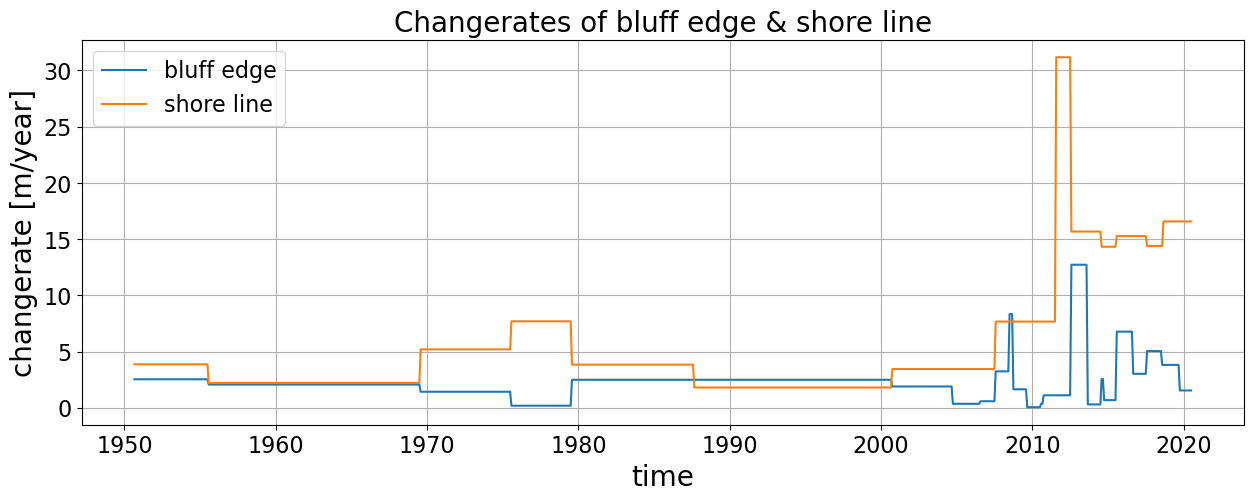

In [15]:
# and plot the rates

fig, ax = plt.subplots(figsize=(15,5))

ax.plot(t, bluff_cr, label='bluff edge')
ax.plot(t, shore_cr, label='shore line')

ax.grid()
ax.legend()
ax.set_title("Changerates of bluff edge & shore line")

ax.set_xlabel('time')
ax.set_ylabel("changerate [m/year]")

;


In [16]:
# rename date column to time column to be consistent
bluff_edges['time'] = bluff_edges['date']
shore_lines['time'] = shore_lines['date']

bluff_edges.drop(labels='date', inplace=True, axis=1)
shore_lines.drop(labels='date', inplace=True, axis=1)

# reorder to keep time in the first column
cols = bluff_edges.columns.tolist()
cols = cols[-1:] + cols[:-1]
bluff_edges = bluff_edges[cols]

cols = shore_lines.columns.tolist()
cols = cols[-1:] + cols[:-1]
shore_lines = shore_lines[cols]

In [17]:
path = "/ts_datasets/"

bluff_edges.to_csv(os.path.join("ts_datasets/", "bluff_edges.csv"))
shore_lines.to_csv(os.path.join("ts_datasets/", "shore_lines.csv"))